In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import attention
import transformers
import torch

import helper
from helper import *

In [14]:
df = load_and_preprocess()
df['Temperature'] = df['Temperature']-273.15 #convert from K to C
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby(df['datetime'].dt.date).agg('mean')
df = df.reset_index()
df.head()

,datetime,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
0,2012-10-01,75.727273,963.920433,12.737980,235.727273,3.272727,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.272727
1,2012-10-02,50.287179,1014.996834,13.787931,260.583333,1.666667,0.125000,0.000000,0.000000,0.0,0.0,0.0,0.000,0.0,0.375000
2,2012-10-03,78.752564,1015.283302,14.224583,227.583333,1.333333,0.125000,0.000000,0.083333,0.0,0.0,0.0,0.125,0.0,0.666667
3,2012-10-04,83.305769,1017.194770,13.710833,101.583333,1.000000,0.083333,0.000000,0.208333,0.0,0.0,0.0,0.250,0.0,1.083333
4,2012-10-05,79.258333,1017.688516,14.385208,66.333333,1.708333,0.333333,0.083333,0.500000,0.0,0.0,0.0,0.000,0.0,2.083333


In [32]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

### Simple LSTM Model

Splitting the dataframe into 75% training data (first 75% of observations), and 25% testing.

In [33]:
train = df[:cutoff].reset_index(drop = True)
train = train.loc[:, 'Temperature'].values.reshape(-1, 1)
test = df[cutoff:]
test = test.loc[:, 'Temperature'].values.reshape(-1, 1)

In [34]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

Splits the sequence (`Temperature` column here) to pass into an LSTM model.<br>
Takes the column as input as well as the number of observations that should be in each X vector.

In [35]:
def split(sequence, n_timestamp):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], sequence[end]
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

In [36]:
X_train, y_train = split(sequence = train_std, n_timestamp = 7)
X_test, y_test = split(sequence = test_std, n_timestamp = 7)

In [37]:
print(X_train.shape)
print(X_test.shape)

(1408, 7, 1)
(465, 7, 1)


In [38]:
print(y_train.shape)
print(y_test.shape)

(1408, 1)
(465, 1)


Simple LSTM model

In [39]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [40]:
model.compile(loss = 'mse', optimizer = 'adam')

In [41]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
36/36 [==============================] - 3s 22ms/step - loss: 0.5050 - val_loss: 0.1879
Epoch 2/20
36/36 [==============================] - 0s 5ms/step - loss: 0.2064 - val_loss: 0.1943
Epoch 3/20
36/36 [==============================] - 0s 6ms/step - loss: 0.2000 - val_loss: 0.1902
Epoch 4/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1959 - val_loss: 0.1858
Epoch 5/20
36/36 [==============================] - 0s 5ms/step - loss: 0.1907 - val_loss: 0.1814
Epoch 6/20
36/36 [==============================] - 0s 5ms/step - loss: 0.1851 - val_loss: 0.1773
Epoch 7/20
36/36 [==============================] - 0s 5ms/step - loss: 0.1795 - val_loss: 0.1735
Epoch 8/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1740 - val_loss: 0.1695
Epoch 9/20
36/36 [==============================] - 0s 5ms/step - loss: 0.1684 - val_loss: 0.1653
Epoch 10/20
36/36 [==============================] - 0s 5ms/step - loss: 0.1628 - val_loss: 0.1608
Epoch 11/20
36/36 

In [42]:
y_pred = model.predict(X_test)

In [43]:
y_test_inv = sc.inverse_transform(y_test)
y_pred_inv = sc.inverse_transform(y_pred)

Plot of actual temperatures and predicted temperatures in a small sample of days (first year of test data)

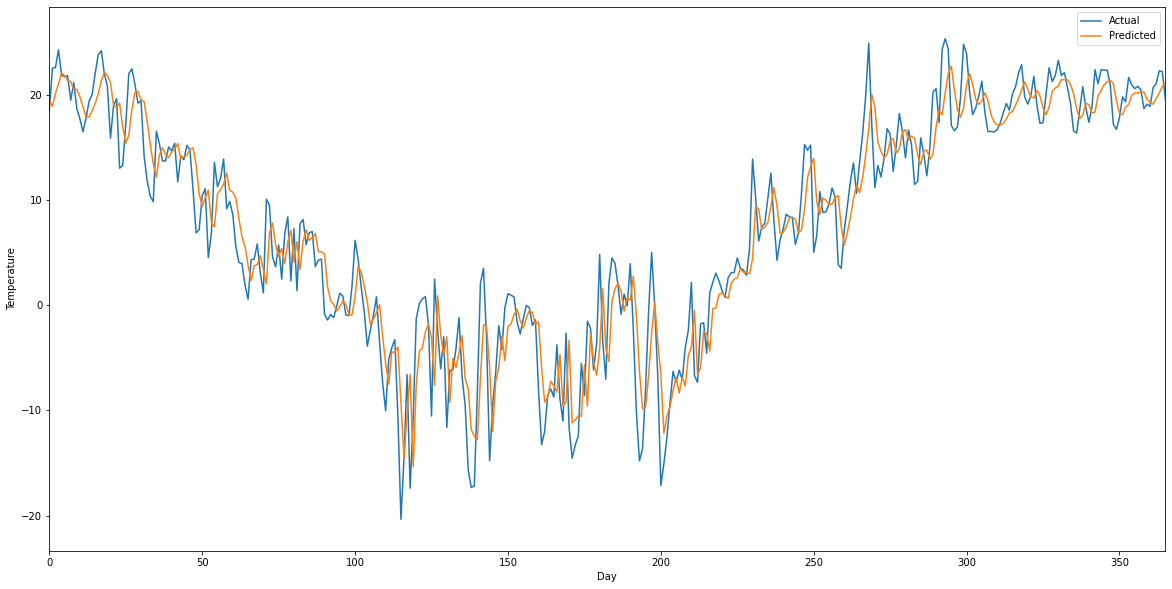

In [44]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [45]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print('MAE:', np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0])

MSE: 12.320398339193783
R-Squared: 0.8876885121996241
RMSE: 3.510042498203374
MAE: 2.6888531647414378


MSE and RMSE are about 1. Will compare to more advanced models below.

### Multivariate Predictions

Splits data into sequences of input variables and corresponding target variable.

In [46]:
def split_multiple(sequence, n_timestamp, target):
    X, y = [], []
    
    for i in range(len(sequence)):
        end = i + n_timestamp
        if end > len(sequence)-1:
            break
        sequence_x, sequence_y = sequence[i:end], target[end] #takes up to n-1 observations in all sequence columns, and the nth observation of the target
        X.append(sequence_x)
        y.append(sequence_y)
    return np.array(X), np.array(y)

Using all numerical variables as inputs and temperature as target.

In [48]:
train = df[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.drop(['datetime'], axis = 1).values

test = df[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.drop(['datetime'], axis = 1).values

In [49]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [50]:
X_train, y_train = split_multiple(train_std, 10, target_train_std)

In [51]:
X_train.shape

(1405, 10, 14)

In [52]:
y_train.shape

(1405, 1)

In [53]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

In [54]:
model.compile(loss = 'mse', optimizer = 'adam')

In [55]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
36/36 [==============================] - 3s 31ms/step - loss: 0.5914 - val_loss: 0.3116
Epoch 2/20
36/36 [==============================] - 0s 8ms/step - loss: 0.3576 - val_loss: 0.1944
Epoch 3/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1942 - val_loss: 0.1863
Epoch 4/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1566 - val_loss: 0.1838
Epoch 5/20
36/36 [==============================] - 0s 7ms/step - loss: 0.1393 - val_loss: 0.1815
Epoch 6/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1275 - val_loss: 0.1785
Epoch 7/20
36/36 [==============================] - 0s 7ms/step - loss: 0.1197 - val_loss: 0.1741
Epoch 8/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1128 - val_loss: 0.1736
Epoch 9/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1070 - val_loss: 0.1719
Epoch 10/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1018 - val_loss: 0.1761
Epoch 11/20
36/36 

In [56]:
X_test, y_test = split_multiple(test_std, 10, target_test_std)

In [57]:
y_pred = model.predict(X_test)

y_test_inv = sc2.inverse_transform(y_test)
y_pred_inv = sc2.inverse_transform(y_pred)

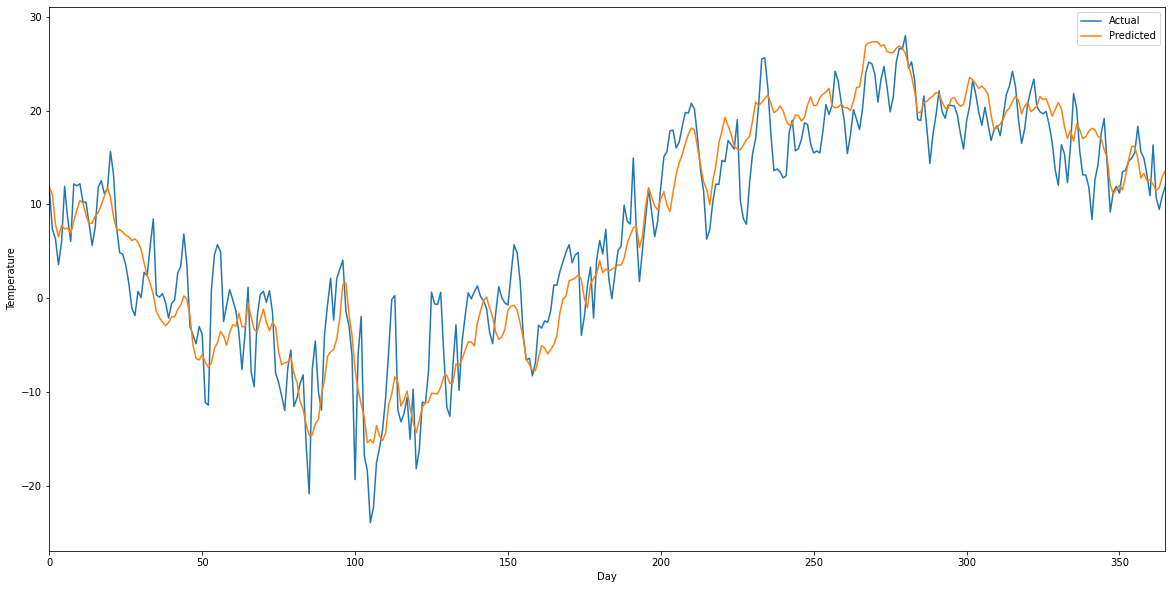

In [58]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [59]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print('MAE:', np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0])

MSE: 20.762246729489977
R-Squared: 0.8516509802140714
RMSE: 4.556560844484574
MAE: 3.5293547985731797


Interestingly, this performs slightly worse than the simpler model. Previous temperatures are the most important indicator of future temperatures, so this makes sense.

### Incorporating Engineered Features

Using engineered features and the 20 most important features as per our RFE analysis.

In [81]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


In [82]:
df['Temperature'] = df['Temperature']-273.15 #convert from K to C
df = df.reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby(df['datetime'].dt.date).agg('mean')
df = df.reset_index()
df.head()

,datetime,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
0,2012-10-09,66.089230,1017.939962,211.400000,1.600000,21.0,285.232000,284.936000,276.244000,280.740000,...,282.16,282.16,78.779569,1015.584173,285.594365,198.334666,1015.878572,1.649181,77.197770,11.464000
1,2012-10-10,70.295512,1016.639540,151.041667,0.666667,11.5,281.564375,281.455833,280.343750,279.812917,...,278.33,282.16,78.779569,1015.584173,285.200150,195.105056,1015.994894,1.572730,76.660958,8.608958
2,2012-10-11,73.292949,1011.541667,178.458333,4.333333,11.5,284.916875,285.063333,284.927917,280.949583,...,274.61,282.16,78.779569,1015.584173,285.106906,190.934585,1015.804353,1.646206,75.755495,11.603125
3,2012-10-12,75.073077,1013.349984,261.125000,4.541667,11.5,280.530417,280.594167,282.150000,285.656250,...,276.61,282.16,78.779569,1015.584173,284.806964,195.095767,1015.324674,1.968341,76.033890,7.351667
4,2012-10-13,67.163461,1016.164556,278.208333,3.333333,11.5,279.679167,279.835833,280.904167,280.943333,...,282.47,282.16,78.779569,1015.584173,284.408095,201.004240,1015.298715,2.189394,75.370301,6.362917


This starts a week after the original dataframe because there are some lagging variables which do not exist for the first observations. This dataset contains data from over 5 years, so one week is not a big deal to drop.

#### LSTM with New Features <br>
Using all the numerical features from above

In [83]:
train = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [84]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [85]:
X_train, y_train = split_multiple(train_std, 7, target_train_std)

In [86]:
X_train.shape

(1408, 7, 21)

In [87]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 50, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.LSTM(units = 50))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [88]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
36/36 [==============================] - 3s 22ms/step - loss: 0.5798 - val_loss: 0.2287
Epoch 2/20
36/36 [==============================] - 0s 6ms/step - loss: 0.2606 - val_loss: 0.2328
Epoch 3/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1836 - val_loss: 0.1771
Epoch 4/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1786 - val_loss: 0.1821
Epoch 5/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1521 - val_loss: 0.1755
Epoch 6/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1442 - val_loss: 0.1742
Epoch 7/20
36/36 [==============================] - 0s 8ms/step - loss: 0.1347 - val_loss: 0.1749
Epoch 8/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1325 - val_loss: 0.1690
Epoch 9/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1326 - val_loss: 0.1810
Epoch 10/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1420 - val_loss: 0.1786
Epoch 11/20
36/36 

In [89]:
X_test, y_test = split_multiple(test_std, 7, target_test_std)

In [90]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

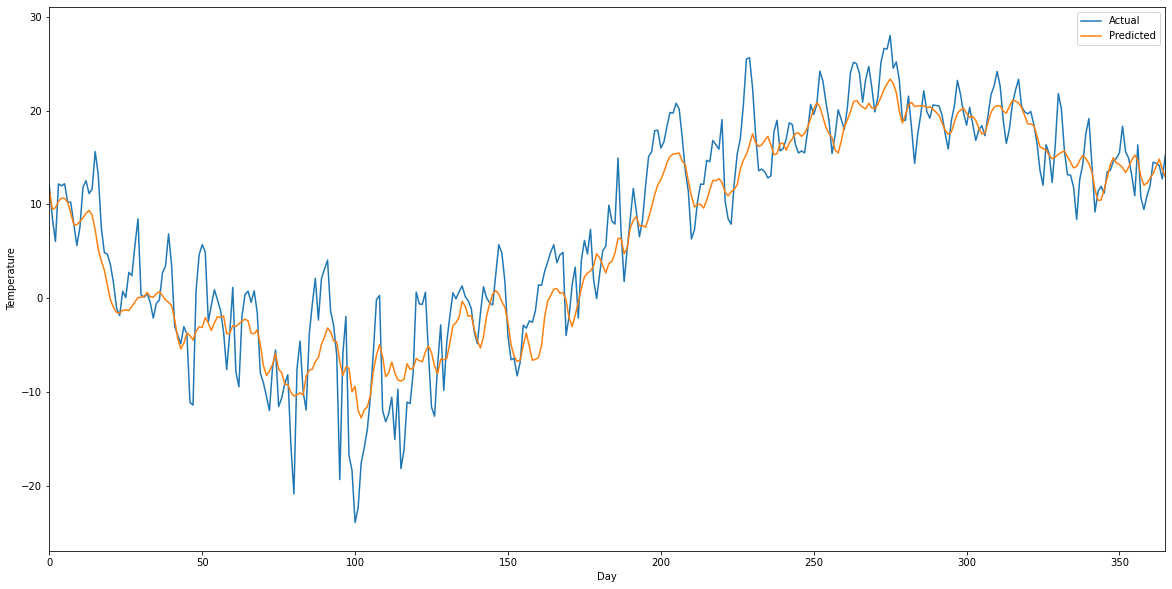

In [91]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [92]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print('MAE:', np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0])

MSE: 16.408024066589654
R-Squared: 0.883161165936125
RMSE: 4.050681926119311
MAE: 3.1326873669967417


Not quite as performant as the original model.

### Transformers

Full disclosure, transformers are a completely novel concept, and the examples that we could find online were nearly exclusively for text-based problems.

#### Attention Model<br>
LSTM with an attention layer.

In [93]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()
df['Temperature'] = df['Temperature']-273.15 #convert from K to C
df = df.reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby(df['datetime'].dt.date).agg('mean')
df = df.reset_index()
df.head()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


,datetime,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
0,2012-10-09,66.089230,1017.939962,211.400000,1.600000,21.0,285.232000,284.936000,276.244000,280.740000,...,282.16,282.16,78.779569,1015.584173,285.594365,198.334666,1015.878572,1.649181,77.197770,11.464000
1,2012-10-10,70.295512,1016.639540,151.041667,0.666667,11.5,281.564375,281.455833,280.343750,279.812917,...,278.33,282.16,78.779569,1015.584173,285.200150,195.105056,1015.994894,1.572730,76.660958,8.608958
2,2012-10-11,73.292949,1011.541667,178.458333,4.333333,11.5,284.916875,285.063333,284.927917,280.949583,...,274.61,282.16,78.779569,1015.584173,285.106906,190.934585,1015.804353,1.646206,75.755495,11.603125
3,2012-10-12,75.073077,1013.349984,261.125000,4.541667,11.5,280.530417,280.594167,282.150000,285.656250,...,276.61,282.16,78.779569,1015.584173,284.806964,195.095767,1015.324674,1.968341,76.033890,7.351667
4,2012-10-13,67.163461,1016.164556,278.208333,3.333333,11.5,279.679167,279.835833,280.904167,280.943333,...,282.47,282.16,78.779569,1015.584173,284.408095,201.004240,1015.298715,2.189394,75.370301,6.362917


In [94]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff
df.head()

,datetime,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
0,2012-10-09,66.089230,1017.939962,211.400000,1.600000,21.0,285.232000,284.936000,276.244000,280.740000,...,282.16,282.16,78.779569,1015.584173,285.594365,198.334666,1015.878572,1.649181,77.197770,11.464000
1,2012-10-10,70.295512,1016.639540,151.041667,0.666667,11.5,281.564375,281.455833,280.343750,279.812917,...,278.33,282.16,78.779569,1015.584173,285.200150,195.105056,1015.994894,1.572730,76.660958,8.608958
2,2012-10-11,73.292949,1011.541667,178.458333,4.333333,11.5,284.916875,285.063333,284.927917,280.949583,...,274.61,282.16,78.779569,1015.584173,285.106906,190.934585,1015.804353,1.646206,75.755495,11.603125
3,2012-10-12,75.073077,1013.349984,261.125000,4.541667,11.5,280.530417,280.594167,282.150000,285.656250,...,276.61,282.16,78.779569,1015.584173,284.806964,195.095767,1015.324674,1.968341,76.033890,7.351667
4,2012-10-13,67.163461,1016.164556,278.208333,3.333333,11.5,279.679167,279.835833,280.904167,280.943333,...,282.47,282.16,78.779569,1015.584173,284.408095,201.004240,1015.298715,2.189394,75.370301,6.362917


In [100]:
train = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [101]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

In [102]:
X_train, y_train = split_multiple(train_std, 7, target_train_std)
X_test, y_test = split_multiple(test_std, 7, target_test_std)
X_train.shape

(1402, 7, 21)

In [103]:
model_input = keras.Input(shape = X_train.shape[1:])
x = keras.layers.LSTM(50, return_sequences = True)(model_input)
x = keras.layers.LSTM(50, return_sequences = True)(x)
x = attention.Attention()(x) #incorportating an attention layer in the model
model_output = keras.layers.Dense(1)(x)
model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 21)]      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 7, 50)        14400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, 7, 50)        20200       lstm_8[0][0]                     
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 50)           0           lstm_9[0][0]                     
______________________________________________________________________________________________

In [104]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
36/36 [==============================] - 3s 23ms/step - loss: 0.4502 - val_loss: 0.2314
Epoch 2/20
36/36 [==============================] - 0s 7ms/step - loss: 0.3440 - val_loss: 0.1891
Epoch 3/20
36/36 [==============================] - 0s 7ms/step - loss: 0.1834 - val_loss: 0.1963
Epoch 4/20
36/36 [==============================] - 0s 7ms/step - loss: 0.1741 - val_loss: 0.2934
Epoch 5/20
36/36 [==============================] - 0s 7ms/step - loss: 0.2158 - val_loss: 0.1866
Epoch 6/20
36/36 [==============================] - 0s 6ms/step - loss: 0.2222 - val_loss: 0.2630
Epoch 7/20
36/36 [==============================] - 0s 6ms/step - loss: 0.2144 - val_loss: 0.2066
Epoch 8/20
36/36 [==============================] - 0s 6ms/step - loss: 0.1609 - val_loss: 0.2727


In [105]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

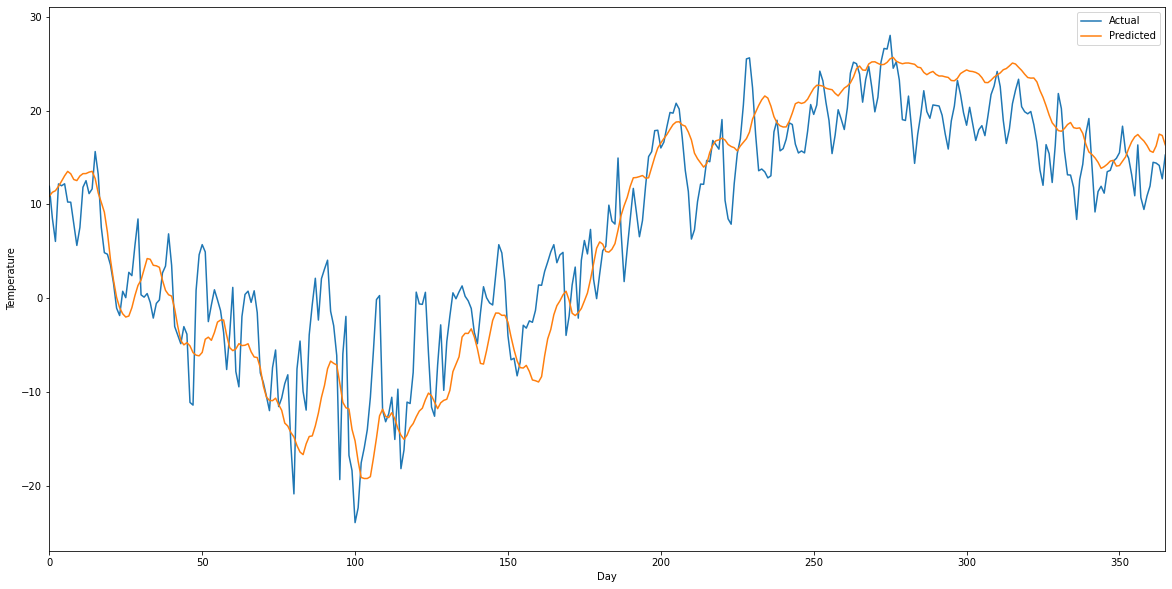

In [106]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [107]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print('MAE:', np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0])

MSE: 32.711644839471745
R-Squared: 0.7669319191138159
RMSE: 5.719409483458213
MAE: 4.4368098355768515


#### Multi-Head Attention Model

This model uses the full transformer architecture for LSTM predictions. Transformers allow for old information to be retained far more effectively than LSTM or RNN models.

In [108]:
df = feature_engineer_important(load_and_preprocess())
df = df.dropna()
df['Temperature'] = df['Temperature']-273.15 #convert from K to C
df = df.reset_index()
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.groupby(df['datetime'].dt.date).agg('mean')
df = df.reset_index()
df.head()

/Users/jakehogan/Desktop/MMA Courses/INSY 695/Assignments/Group Project/Cloud-Computations/helper.py:139: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week'] = df['datetime'].dt.weekofyear


,datetime,Humidity,Wind Direction,Pressure,Wind Speed,hour,lag1,lag2,lag12,lag30,...,min daily pressure,min weekly temp,mean weekly hum,mean weekly wind direction,rolling_mean_temp,rolling_mean_pressure,rolling_mean_wind_dir,rolling_mean_wind_speed,rolling_mean_humidity,Temperature
0,2012-10-09,66.089230,1017.939962,211.400000,1.600000,21.0,285.232000,284.936000,276.244000,280.740000,...,282.16,282.16,78.779569,1015.584173,285.594365,198.334666,1015.878572,1.649181,77.197770,11.464000
1,2012-10-10,70.295512,1016.639540,151.041667,0.666667,11.5,281.564375,281.455833,280.343750,279.812917,...,278.33,282.16,78.779569,1015.584173,285.200150,195.105056,1015.994894,1.572730,76.660958,8.608958
2,2012-10-11,73.292949,1011.541667,178.458333,4.333333,11.5,284.916875,285.063333,284.927917,280.949583,...,274.61,282.16,78.779569,1015.584173,285.106906,190.934585,1015.804353,1.646206,75.755495,11.603125
3,2012-10-12,75.073077,1013.349984,261.125000,4.541667,11.5,280.530417,280.594167,282.150000,285.656250,...,276.61,282.16,78.779569,1015.584173,284.806964,195.095767,1015.324674,1.968341,76.033890,7.351667
4,2012-10-13,67.163461,1016.164556,278.208333,3.333333,11.5,279.679167,279.835833,280.904167,280.943333,...,282.47,282.16,78.779569,1015.584173,284.408095,201.004240,1015.298715,2.189394,75.370301,6.362917


In [109]:
cutoff = math.floor(0.75*len(df)) #train/test cutoff

In [110]:
train = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_train = train[['Temperature']].values
train = train.values

test = df.drop('datetime', axis=1)[:cutoff].reset_index(drop = True)
target_test = test[['Temperature']].values
test = test.values

In [111]:
sc = StandardScaler()
sc2 = StandardScaler()
train_std = sc.fit_transform(train)
target_train_std = sc2.fit_transform(target_train)
test_std = sc.transform(test)
target_test_std = sc2.transform(target_test)

Constructing classes for the transformers as per this kaggle example below.<br>

In [112]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer
import keras.backend as K

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass


embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=10, d_k=64, d_v=64, layers=2, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(2, activation="softmax")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'Adamax', loss = 'binary_crossentropy', metrics=['accuracy'])

In [114]:
X_train, y_train = split_multiple(train_std, 7, target_train_std)
X_test, y_test = split_multiple(test_std, 7, target_test_std)
X_train.shape

(1402, 7, 21)

Creating a transformer architecture model.

In [115]:
model_input = keras.Input(shape = X_train.shape[1:])

x = keras.layers.Bidirectional(LSTM(128, return_sequences=True))(model_input)
x = keras.layers.Bidirectional(LSTM(64, return_sequences=True))(x)

x, self_attn = MultiHeadAttention(n_head = 3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation='sigmoid')(conc)
model_output = Dense(1)(conc)

model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 7, 21)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 7, 256)       153600      input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 7, 128)       164352      bidirectional[0][0]              
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 7, 192)       24576       bidirectional_1[0][0]            
____________________________________________________________________________________________

In [116]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
36/36 [==============================] - 6s 45ms/step - loss: 1.3638 - val_loss: 1.1513
Epoch 2/20
36/36 [==============================] - 1s 15ms/step - loss: 0.6116 - val_loss: 1.5367
Epoch 3/20
36/36 [==============================] - 1s 17ms/step - loss: 0.4099 - val_loss: 0.4477
Epoch 4/20
36/36 [==============================] - 1s 14ms/step - loss: 0.3022 - val_loss: 0.4527
Epoch 5/20
36/36 [==============================] - 1s 15ms/step - loss: 0.2246 - val_loss: 0.3433
Epoch 6/20
36/36 [==============================] - 1s 15ms/step - loss: 0.2101 - val_loss: 0.2353
Epoch 7/20
36/36 [==============================] - 1s 15ms/step - loss: 0.1699 - val_loss: 0.2745
Epoch 8/20
36/36 [==============================] - 1s 15ms/step - loss: 0.1741 - val_loss: 0.2890
Epoch 9/20
36/36 [==============================] - 1s 15ms/step - loss: 0.2391 - val_loss: 0.3550


In [117]:
y_pred = model.predict(X_test)

y_pred_inv = sc2.inverse_transform(y_pred)
y_test_inv = sc2.inverse_transform(y_test)

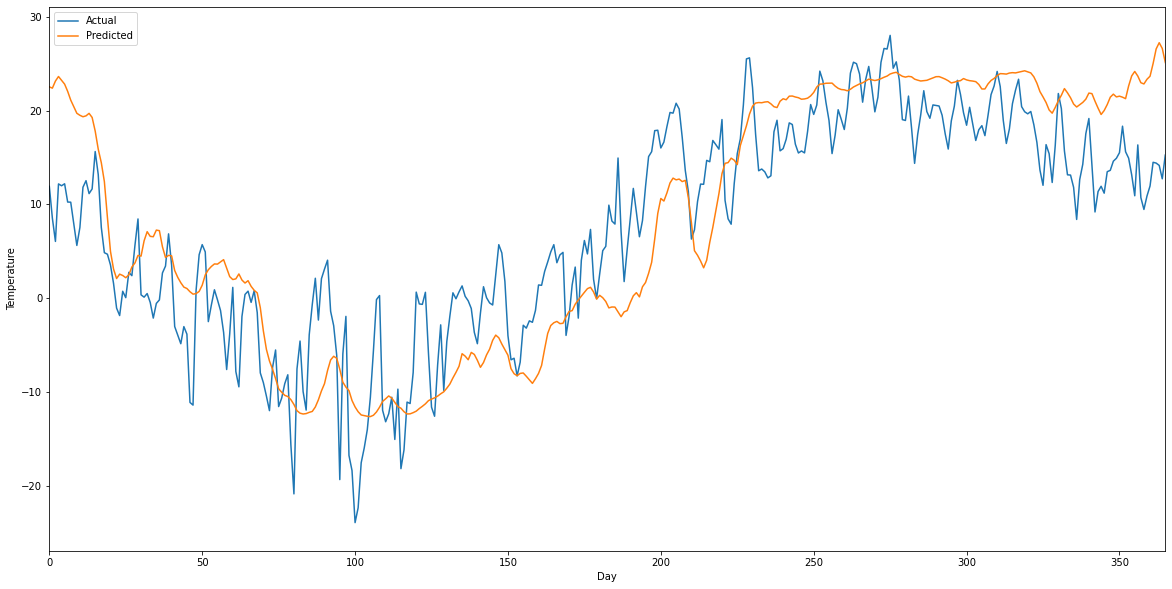

In [118]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [119]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print('MAE:', np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0])

MSE: 53.45520544791291
R-Squared: 0.6191355644675999
RMSE: 7.311306685395772
MAE: 6.024480517210799


This seems to perform a lot worse than some of the original models. I'm not comfortable enough with transformers to confidently explain why, but I conjecture that weather prediction is a simple problem which transformers may just be too complex a solution to effectively implement.

#### Simple Transformer

Trying transformers with just previous temperatures as inputs

In [130]:
data = load_and_preprocess()
data = data.dropna()
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.groupby(data['datetime'].dt.date).agg('mean')
data['Temperature'] = data['Temperature']-273.15
data = data.reset_index()
df = data[['datetime', 'Temperature']]
df.head()

,datetime,Temperature
0,2012-10-01,12.737980
1,2012-10-02,13.787931
2,2012-10-03,14.224583
3,2012-10-04,13.710833
4,2012-10-05,14.385208


In [131]:
cutoff = int(len(df)*0.75)

train = df[:cutoff].reset_index(drop = True)
train = train.loc[:, 'Temperature'].values.reshape(-1, 1)
test = df[cutoff:]
test = test.loc[:, 'Temperature'].values.reshape(-1, 1)

In [132]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [133]:
X_train, y_train = split(train_std, n_timestamp=7)
X_test, y_test = split(test_std, n_timestamp=7)

In [134]:
model_input = keras.Input(shape = X_train.shape[1:])

x = keras.layers.Bidirectional(LSTM(64, return_sequences=True))(model_input)
x = keras.layers.Bidirectional(LSTM(32, return_sequences=True))(x)

x, self_attn = MultiHeadAttention(n_head = 3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(64, activation='sigmoid')(conc)
model_output = Dense(1)(conc)

model = keras.models.Model(model_input, model_output)

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 7, 128)       33792       input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 7, 64)        41216       bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 7, 192)       12288       bidirectional_3[0][0]            
____________________________________________________________________________________________

In [135]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
36/36 [==============================] - 6s 42ms/step - loss: 1.0488 - val_loss: 0.3958
Epoch 2/20
36/36 [==============================] - 0s 12ms/step - loss: 0.3213 - val_loss: 0.2921
Epoch 3/20
36/36 [==============================] - 0s 11ms/step - loss: 0.2443 - val_loss: 0.2865
Epoch 4/20
36/36 [==============================] - 0s 13ms/step - loss: 0.2388 - val_loss: 0.2235
Epoch 5/20
36/36 [==============================] - 0s 13ms/step - loss: 0.2309 - val_loss: 0.1972
Epoch 6/20
36/36 [==============================] - 0s 11ms/step - loss: 0.1739 - val_loss: 0.1741
Epoch 7/20
36/36 [==============================] - 0s 11ms/step - loss: 0.1865 - val_loss: 0.1823
Epoch 8/20
36/36 [==============================] - 0s 11ms/step - loss: 0.1804 - val_loss: 0.2103
Epoch 9/20
36/36 [==============================] - 0s 12ms/step - loss: 0.2045 - val_loss: 0.1867


In [136]:
y_pred = model.predict(X_test)

y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

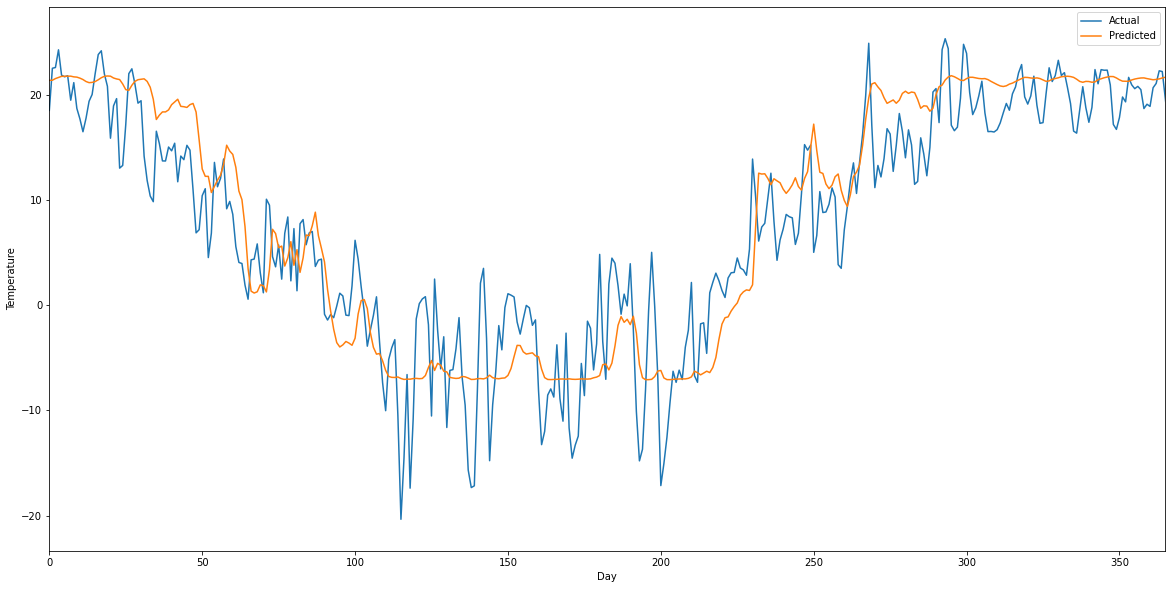

In [137]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual')
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([y_test_inv[0:365].min()-3, y_test_inv[0:365].max()+3])
plt.legend()
plt.show()

In [138]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print('MAE:', np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0])

MSE: 23.131987970448773
R-Squared: 0.7891311698521343
RMSE: 4.809572535106293
MAE: 3.8506791898394503


-----

Moving with the basic LSTM - that was the most performant model (probably because most recent temperatures are the most important indicators of future temperatures).

In [139]:
data = load_and_preprocess()
data = data.dropna()
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.groupby(data['datetime'].dt.date).agg('mean')
data['Temperature'] = data['Temperature']-273.15
data = data.reset_index()
df = data[['datetime', 'Temperature']]
df.head()

,datetime,Temperature
0,2012-10-01,12.737980
1,2012-10-02,13.787931
2,2012-10-03,14.224583
3,2012-10-04,13.710833
4,2012-10-05,14.385208


In [140]:
cutoff = int(len(df)*0.75)

In [141]:
train = df[:cutoff].reset_index(drop = True)
train = train.loc[:, 'Temperature'].values.reshape(-1, 1)
test = df[cutoff:]
test = test.loc[:, 'Temperature'].values.reshape(-1, 1)

In [142]:
sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

In [143]:
X_train, y_train = split(train_std, n_timestamp=24)
X_test, y_test = split(test_std, n_timestamp=24)

In [144]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [145]:
history = model.fit(X_train, y_train, epochs = 20, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False)

Epoch 1/20
35/35 [==============================] - 4s 28ms/step - loss: 0.4191 - val_loss: 0.2137
Epoch 2/20
35/35 [==============================] - 0s 14ms/step - loss: 0.2195 - val_loss: 0.1995
Epoch 3/20
35/35 [==============================] - 1s 15ms/step - loss: 0.1917 - val_loss: 0.1913
Epoch 4/20
35/35 [==============================] - 0s 13ms/step - loss: 0.1889 - val_loss: 0.1865
Epoch 5/20
35/35 [==============================] - 0s 12ms/step - loss: 0.1855 - val_loss: 0.1834
Epoch 6/20
35/35 [==============================] - 0s 13ms/step - loss: 0.1824 - val_loss: 0.1800
Epoch 7/20
35/35 [==============================] - 0s 12ms/step - loss: 0.1790 - val_loss: 0.1763
Epoch 8/20
35/35 [==============================] - 0s 12ms/step - loss: 0.1752 - val_loss: 0.1722
Epoch 9/20
35/35 [==============================] - 0s 13ms/step - loss: 0.1710 - val_loss: 0.1678
Epoch 10/20
35/35 [==============================] - 0s 13ms/step - loss: 0.1665 - val_loss: 0.1633
Epoch 11/

In [146]:
y_pred = model.predict(X_test)
y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

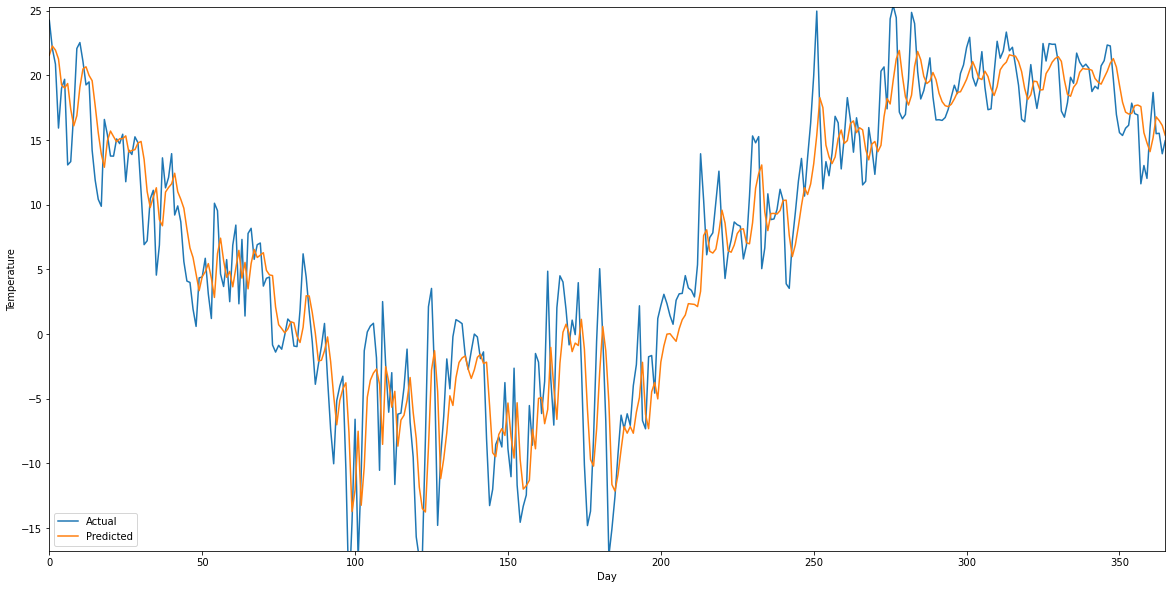

In [149]:
from matplotlib import pyplot as plt
plt.figure(figsize = (20, 10))
plt.plot(y_test_inv, label = 'Actual') 
plt.plot(y_pred_inv, label = 'Predicted')
plt.ylabel('Temperature')
plt.xlabel('Day')
plt.xlim([0, 365])
plt.ylim([min(y_pred_inv[:366])-3, max(y_pred_inv[:366])+3])
plt.legend()
plt.show()

In [150]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print('MAE:', np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0])

MSE: 13.616781321812056
R-Squared: 0.8736141646504831
RMSE: 3.6900923188738863
MAE: 2.832399867533148


Custom function to build an LSTM model and test performance.

Adjusting the dataset to predict average daily temperature in order to speed up training times. This method will also likely be used in our final analysis as it is slightly more intutitive.

In [151]:
df['datetime'] = pd.to_datetime(df['datetime'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [153]:
cutoff = int(len(df)*0.75)

train = df[:cutoff].reset_index(drop = True)
train = train.loc[:, 'Temperature'].values.reshape(-1, 1)
test = df[cutoff:]
test = test.loc[:, 'Temperature'].values.reshape(-1, 1)

sc = StandardScaler()
train_std = sc.fit_transform(train)
test_std = sc.transform(test)

X_train, y_train = split(train_std, 10)
X_test, y_test = split(test_std, 10)

In [154]:
X_train.shape, y_train.shape

((1405, 10, 1), (1405, 1))

We tested Ludwig in another notebook, and AutoKeras does not have time series functionality, so we're making our own hyperparameter optimization method. The models tend to perform much worse than ARIMA and XGBoost, so it is more of a formality than anything.

In [155]:
def build_lstm(X_train, n_layers = 2, cell_range = [32, 128], dropout = 0, batchnorm = False):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X_train.shape[1:]))
    
    for i in range(n_layers-1):
        model.add(keras.layers.LSTM(random.randint(cell_range[0], cell_range[1]), return_sequences=True))
        model.add(keras.layers.Dropout(dropout))
        if batchnorm:
            model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LSTM(random.randint(cell_range[0], cell_range[1])))
    model.add(keras.layers.Dropout(dropout))
    if batchnorm:
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    return model, {'n_layers': n_layers, 'cell_min': cell_range[0], 'cell_max': cell_range[1], 'dropout': dropout, 'batchnorm': batchnorm}

In [165]:
def model_performance(model):
    history = model.fit(X_train, y_train, epochs = 25, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.2, shuffle=False, verbose = 0)
    y_pred = model.predict(X_test)
    y_pred_inv = sc.inverse_transform(y_pred)
    y_test_inv = sc.inverse_transform(y_test)
    
    return mean_squared_error(y_test_inv, y_pred_inv), r2_score(y_test_inv, y_pred_inv), math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)), np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0]

Training many different models to assess performance.

In [166]:
import random
attributes = dict()
for i in range(10):
    model, atts = build_lstm(X_train, n_layers = random.randint(2, 8), cell_range = [32, 128], dropout = random.uniform(0, 0.4), batchnorm = random.choice([True, False]))
    mse, r2, rmse, mae = model_performance(model)
    atts['MSE'] = mse
    atts['R2'] = r2
    atts['RMSE'] = rmse
    atts['MAE'] = mae
    print(str(i+1)+' models tested')
    attributes[i] = atts

1 models tested
2 models tested
3 models tested
4 models tested
5 models tested
6 models tested
7 models tested
8 models tested
9 models tested
10 models tested


In [167]:
atts = pd.DataFrame.from_dict(attributes, orient='index')

In [168]:
atts

,n_layers,cell_min,cell_max,dropout,batchnorm,MSE,R2,RMSE,MAE
0,5,32,128,0.171917,False,31.638296,0.710532,5.624793,4.379665
1,5,32,128,0.137963,True,106.459505,0.025970,10.317922,8.850061
2,5,32,128,0.190219,False,33.668902,0.691953,5.802491,4.506075
3,6,32,128,0.204668,True,107.934978,0.012471,10.389176,8.940312
4,6,32,128,0.364912,False,32.937061,0.698649,5.739082,4.502388
5,5,32,128,0.159851,False,25.760536,0.764309,5.075484,3.970895
6,3,32,128,0.161254,False,14.141957,0.870611,3.760579,2.894038
7,5,32,128,0.044401,False,30.913783,0.717161,5.560016,4.427011
8,5,32,128,0.164428,False,24.913692,0.772057,4.991362,3.896776
9,6,32,128,0.048467,False,30.571266,0.720294,5.529129,4.435146


Most performant models after a lot of testing contained a small number of layers (like 2-4), and no batch normalization. Dropout did not seem to impact performance much. These models were significantly less performant than the ARIMA and XGBoost ones chosen in our other analysis, however. So, we decided to move forward with an ARIMA model that showed ~0.5-0.6 RMSE.

In [169]:
model = keras.models.Sequential()

model.add(keras.layers.LSTM(units = 64, return_sequences = True, input_shape = X_train.shape[1:]))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(units = 64, return_sequences = True))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.LSTM(units = 64))
model.add(keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')

In [170]:
history = model.fit(X_train, y_train, epochs = 100, callbacks=[keras.callbacks.EarlyStopping(patience=3)], validation_split=0.1, shuffle=False)

Epoch 1/100
40/40 [==============================] - 5s 32ms/step - loss: 0.4710 - val_loss: 0.2057
Epoch 2/100
40/40 [==============================] - 0s 11ms/step - loss: 0.2279 - val_loss: 0.2049
Epoch 3/100
40/40 [==============================] - 0s 10ms/step - loss: 0.2307 - val_loss: 0.1734
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2181 - val_loss: 0.1728
Epoch 5/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2142 - val_loss: 0.1689
Epoch 6/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2098 - val_loss: 0.1647
Epoch 7/100
40/40 [==============================] - 0s 9ms/step - loss: 0.2028 - val_loss: 0.1598
Epoch 8/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1985 - val_loss: 0.1545
Epoch 9/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1929 - val_loss: 0.1497
Epoch 10/100
40/40 [==============================] - 0s 9ms/step - loss: 0.1836 - val_loss: 0.1440
Epoch 

In [171]:
y_pred = model.predict(X_test)
y_pred_inv = sc.inverse_transform(y_pred)
y_test_inv = sc.inverse_transform(y_test)

In [172]:
y_pred.shape

(462, 1)

Keep in mind, this was a model with the aggregated daily temperatures.

In [173]:
print('MSE:', mean_squared_error(y_test_inv, y_pred_inv))
print('R-Squared:', r2_score(y_test_inv, y_pred_inv))
print('RMSE:', math.sqrt(mean_squared_error(y_test_inv, y_pred_inv)))
print('MAE:', np.mean(np.abs(y_test_inv - y_pred_inv), axis=0)[0])

MSE: 11.310541923950339
R-Squared: 0.8965164958369144
RMSE: 3.3631149138782543
MAE: 2.5111003491074606


### Conclusion

In summary, the best LSTM models were the simple ones which considered only previous temperatures as inputs as opposed to more complicated models with many variables. However, the LSTM and Transformer models tested perform worse than the ARIMA and XGBoost models that we tested.